In [1]:
import glob
import torch
import torch.nn as nn
import numpy as np
from torch.utils.data.dataset import Dataset
import matplotlib.pyplot as plt
from PIL import Image
from tqdm.auto import tqdm
from torchvision.transforms import Compose, ToTensor, Resize, Normalize, RandomHorizontalFlip, ToPILImage
from torch.optim.adam import Adam
from torch.utils.data.dataloader import DataLoader
import torchvision.models as models
import random
import os
import cv2
import albumentations as A
from albumentations.pytorch import ToTensorV2
from IPython.core.debugger import set_trace
import pandas as pd
import datetime
import pytz
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2
import openpyxl
import torch.nn.functional as F

## 파라미터 설정

In [2]:
# os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [4]:
'''
# 맥 mps 설정
device = torch.device("mps:0" if torch.backends.mps.is_available() else "cpu")
print(f"현재 디바이스는 {device} 입니다.")
'''

'\n# 맥 mps 설정\ndevice = torch.device("mps:0" if torch.backends.mps.is_available() else "cpu")\nprint(f"현재 디바이스는 {device} 입니다.")\n'

In [5]:
CFG = {
    'IMG_SIZE':512,
    'EPOCHS':10,
    'LEARNING_RATE':1e-4,
    'BATCH_SIZE': 64,
    'SEED':41,
    'MEAN' : [0.485, 0.456, 0.406],
    'STD'  : [0.229, 0.224, 0.225],
    'train_magnification':20,
    'test_magnification':20,
}

In [6]:
kst = pytz.timezone('Asia/Seoul')
current_datetime = datetime.datetime.now(kst)
formatted_datetime = current_datetime.strftime("%Y_%m_%d_%I:%M_%p")
print(formatted_datetime)

2023_06_05_05:47_PM


In [7]:
# server path
pth_name=f"/data/pthfile/train:{CFG['train_magnification']}X_test:{CFG['test_magnification']}X_epoch:{CFG['EPOCHS']}_({formatted_datetime}).pth"
output_name = f"train:{CFG['train_magnification']}X_test:{CFG['test_magnification']}X_epoch:{CFG['EPOCHS']}"
output_path = f"/data/output/output_{output_name}_({formatted_datetime})"
plot_path = f"/data/plot/plot_{output_name}_({formatted_datetime})"
train_data_path = f"/data/PDA_mask_img/train/{CFG['train_magnification']}X/**/*.png"
test_data_path = f"/data/PDA_mask_img/test_mask/{CFG['test_magnification']}X/**/*.png"
val_data_path = f"/data/PDA_mask_img/validation_mask/{CFG['train_magnification']}X/**/*.png"


print(f"pth_name:{pth_name}")
print(f"output_path:{output_path}")
print(f"plot_path:{plot_path}")
print(f"train_data_path:{train_data_path}")
print(f"test_data_path:{test_data_path}")
print(f"test_data_path:{val_data_path}")

pth_name:/data/pthfile/train:20X_test:20X_epoch:10_(2023_06_05_05:47_PM).pth
output_path:/data/output/output_train:20X_test:20X_epoch:10_(2023_06_05_05:47_PM)
plot_path:/data/plot/plot_train:20X_test:20X_epoch:10_(2023_06_05_05:47_PM)
train_data_path:/data/PDA_mask_img/train/20X/**/*.png
test_data_path:/data/PDA_mask_img/test_mask/20X/**/*.png
test_data_path:/data/PDA_mask_img/validation_mask/20X/**/*.png


In [8]:
# local path
'''
pth_name=f"git_ignore/pthfile/train:{CFG['train_magnification']}X_test:{CFG['test_magnification']}X_epoch:{CFG['EPOCHS']}_({formatted_datetime}).pth"
output_name = f"train:{CFG['train_magnification']}X_test:{CFG['test_magnification']}X_epoch:{CFG['EPOCHS']}"
output_path = f"git_ignore/output/output_{output_name}_({formatted_datetime})"
plot_path = f"git_ignore/plot/plot_{output_name}_({formatted_datetime})"
train_data_path = f"git_ignore/PDA_mask_img/train/{CFG['train_magnification']}X/**/*.png"
test_data_path = f"git_ignore/PDA_mask_img/test/{CFG['test_magnification']}X/**/*.png"
val_data_path = f"git_ignore/PDA_mask_img/validation/{CFG['train_magnification']}X/**/*.png"


print(f"pth_name:{pth_name}")
print(f"output_path:{output_path}")
print(f"plot_path:{plot_path}")
print(f"train_data_path:{train_data_path}")
print(f"test_data_path:{test_data_path}")
print(f"test_data_path:{val_data_path}")
'''

'\npth_name=f"git_ignore/pthfile/train:{CFG[\'train_magnification\']}X_test:{CFG[\'test_magnification\']}X_epoch:{CFG[\'EPOCHS\']}_({formatted_datetime}).pth"\noutput_name = f"train:{CFG[\'train_magnification\']}X_test:{CFG[\'test_magnification\']}X_epoch:{CFG[\'EPOCHS\']}"\noutput_path = f"git_ignore/output/output_{output_name}_({formatted_datetime})"\nplot_path = f"git_ignore/plot/plot_{output_name}_({formatted_datetime})"\ntrain_data_path = f"git_ignore/PDA_mask_img/train/{CFG[\'train_magnification\']}X/**/*.png"\ntest_data_path = f"git_ignore/PDA_mask_img/test/{CFG[\'test_magnification\']}X/**/*.png"\nval_data_path = f"git_ignore/PDA_mask_img/validation/{CFG[\'train_magnification\']}X/**/*.png"\n\n\nprint(f"pth_name:{pth_name}")\nprint(f"output_path:{output_path}")\nprint(f"plot_path:{plot_path}")\nprint(f"train_data_path:{train_data_path}")\nprint(f"test_data_path:{test_data_path}")\nprint(f"test_data_path:{val_data_path}")\n'

In [9]:
# 시드 고정
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(CFG['SEED']) # Seed 고정

## 데이터 경로지정

In [10]:
train_path_list = sorted(glob.glob(train_data_path))
train_mask_path = train_path_list[0::2]
train_img_path = train_path_list[1::2]
train_mask_path[:5]

['/data/PDA_mask_img/train/20X/C3L-00017-22/C3L-00017-22 [d=1.01174,x=10073,y=10073,w=518,h=518]-labelled.png',
 '/data/PDA_mask_img/train/20X/C3L-00017-22/C3L-00017-22 [d=1.01174,x=10073,y=10338,w=518,h=518]-labelled.png',
 '/data/PDA_mask_img/train/20X/C3L-00017-22/C3L-00017-22 [d=1.01174,x=10073,y=10603,w=518,h=518]-labelled.png',
 '/data/PDA_mask_img/train/20X/C3L-00017-22/C3L-00017-22 [d=1.01174,x=10073,y=11663,w=518,h=518]-labelled.png',
 '/data/PDA_mask_img/train/20X/C3L-00017-22/C3L-00017-22 [d=1.01174,x=10073,y=11928,w=518,h=518]-labelled.png']

In [11]:
test_path_list = sorted(glob.glob(test_data_path))
test_mask_path = test_path_list[0::2]
test_img_path = test_path_list[1::2]
test_mask_path[:5]

['/data/PDA_mask_img/test_mask/20X/C3L-01637-21/C3L-01637-21 [d=1.01174,x=10360,y=3108,w=518,h=518]-labelled.png',
 '/data/PDA_mask_img/test_mask/20X/C3L-01637-21/C3L-01637-21 [d=1.01174,x=10360,y=3626,w=518,h=518]-labelled.png',
 '/data/PDA_mask_img/test_mask/20X/C3L-01637-21/C3L-01637-21 [d=1.01174,x=10360,y=4144,w=518,h=518]-labelled.png',
 '/data/PDA_mask_img/test_mask/20X/C3L-01637-21/C3L-01637-21 [d=1.01174,x=10360,y=4662,w=518,h=518]-labelled.png',
 '/data/PDA_mask_img/test_mask/20X/C3L-01637-21/C3L-01637-21 [d=1.01174,x=10878,y=3626,w=518,h=518]-labelled.png']

In [12]:
val_path_list = sorted(glob.glob(val_data_path))
val_mask_path = val_path_list[0::2]
val_img_path = val_path_list[1::2]
val_mask_path[:5]

['/data/PDA_mask_img/validation_mask/20X/C3L-00277-22/C3L-00277-22 [d=1.01174,x=10360,y=15022,w=518,h=518]-labelled.png',
 '/data/PDA_mask_img/validation_mask/20X/C3L-00277-22/C3L-00277-22 [d=1.01174,x=10360,y=15540,w=518,h=518]-labelled.png',
 '/data/PDA_mask_img/validation_mask/20X/C3L-00277-22/C3L-00277-22 [d=1.01174,x=10360,y=16058,w=518,h=518]-labelled.png',
 '/data/PDA_mask_img/validation_mask/20X/C3L-00277-22/C3L-00277-22 [d=1.01174,x=10360,y=16576,w=518,h=518]-labelled.png',
 '/data/PDA_mask_img/validation_mask/20X/C3L-00277-22/C3L-00277-22 [d=1.01174,x=10360,y=18130,w=518,h=518]-labelled.png']

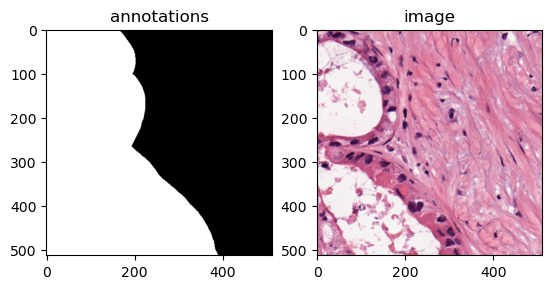

In [13]:
annotation = cv2.imread(train_mask_path[5])
image = cv2.imread(train_img_path[5])
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.subplot(1,2,1)
plt.title("annotations")
plt.imshow(annotation)

plt.subplot(1,2,2)
plt.title("image")
plt.imshow(image)

In [14]:
# Custom Dataset
class CustomDataset(Dataset):
    def __init__(self, img_path, mask_path, transform = None):
        self.image = img_path
        self.mask = mask_path
        
        n_samples =  len(self.image)
        
        # 데이터 미리 섞어줌
        np.random.seed(CFG['SEED'])
        idxs = np.random.permutation(range(n_samples))
        
        self.image = np.array(self.image)[idxs]
        self.mask = np.array(self.mask)[idxs]
        self.transform = transform

    def __len__(self):
        return len(self.image) # 데이터셋 길이
    
    def __getitem__(self, i):
        image = np.array(Image.open(self.image[i]))
        mask = np.array(Image.open(self.mask[i]))
        data = self.transform(image = image, mask = mask)
        image = data["image"]
        mask = data["mask"]
        return image, mask

In [15]:
class UNet(nn.Module):
    def __init__(self, num_classes):
        super(UNet, self).__init__()
        self.encoder = models.resnet18(pretrained=True)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.relu = nn.ReLU(inplace=True)
        self.upconv1 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.conv1 = nn.Conv2d(512, 256, kernel_size=3, padding=1)
        self.upconv2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(256, 128, kernel_size=3, padding=1)
        self.upconv3 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.conv3 = nn.Conv2d(128, 64, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(64, num_classes, kernel_size=1)

    def forward(self, x):
        # Encoder
        x1 = self.encoder.conv1(x)
        x1 = self.encoder.bn1(x1)
        x1 = self.encoder.relu(x1)
        x1 = self.encoder.maxpool(x1)

        x2 = self.encoder.layer1(x1)
        x3 = self.encoder.layer2(x2)
        x4 = self.encoder.layer3(x3)
        x5 = self.encoder.layer4(x4)

        # Decoder
        x = self.upconv1(x5)
        x = torch.cat((x, x4), dim=1)
        x = self.relu(self.conv1(x))

        x = self.upconv2(x)
        x = torch.cat((x, x3), dim=1)
        x = self.relu(self.conv2(x))

        x = self.upconv3(x)
        x = torch.cat((x, x2), dim=1)
        x = self.relu(self.conv3(x))

        x = self.conv4(x)

        # Resize to 512x512
        x = nn.functional.interpolate(x, size=(512, 512), mode='bilinear', align_corners=False)

        return x

## 데이터 불러오기

In [16]:
train_transform = A.Compose([
        A.Resize(CFG['IMG_SIZE'],CFG['IMG_SIZE']),
        A.Normalize(mean=CFG['MEAN'], std = CFG['STD']),
        A.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
        A.OneOf([
                A.HorizontalFlip(p=0.3),
                A.RandomRotate90(p=0.3),
                A.VerticalFlip(p=0.3)            
        ], p=0.3),
        ToTensorV2(transpose_mask=True)
])

'''
A.OneOf([
        A.MotionBlur(p=0.3),
        A.OpticalDistortion(p=0.3),
        A.GaussNoise(p=0.3)                 
], p=0.3),
'''

'\nA.OneOf([\n        A.MotionBlur(p=0.3),\n        A.OpticalDistortion(p=0.3),\n        A.GaussNoise(p=0.3)                 \n], p=0.3),\n'

In [17]:
test_transform = A.Compose([
        A.Resize(CFG['IMG_SIZE'],CFG['IMG_SIZE']),
        A.Normalize(mean=CFG['MEAN'], std = CFG['STD']),
        ToTensorV2(transpose_mask=True)
])

In [18]:
# 학습용 데이터
train_set = CustomDataset(img_path = train_img_path,
                          mask_path = train_mask_path,
                          transform = train_transform)

val_set = CustomDataset(img_path = val_img_path,
                         mask_path= val_mask_path,
                         transform = test_transform)
# 테스트 데이터
test_set = CustomDataset(img_path = test_img_path,
                         mask_path=test_mask_path,
                         transform = test_transform)

In [19]:
train_loader = DataLoader(train_set, batch_size = CFG["BATCH_SIZE"], shuffle = True)
val_loader = DataLoader(val_set, batch_size = CFG["BATCH_SIZE"])
test_loader = DataLoader(test_set, batch_size = CFG["BATCH_SIZE"])

In [20]:
print(f"train_data : {len(train_set)} / val_data : {len(val_set)} / test_data : {len(test_set)}")

train_data : 4427 / val_data : 445 / test_data : 81


## 학습

In [21]:
class DiceLoss(nn.Module):
    def __init__(self):
        super(DiceLoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):
        
        inputs = F.sigmoid(inputs) # sigmoid를 통과한 출력이면 주석처리
        
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        
        intersection = (inputs * targets).sum()                            
        dice = (2.*intersection + smooth) / (inputs.sum() + targets.sum() + smooth)  
        
        return 1 - dice 

In [22]:
# 학습 파라미터
model = UNet(num_classes=1).to(device)
model = nn.DataParallel(model)
optimizer = Adam(params = model.parameters(), lr = CFG["LEARNING_RATE"])
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=2, threshold_mode='abs', min_lr=1e-8, verbose=True)
criterion = DiceLoss().to(device)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [23]:
def dice_score(pred, target, smooth=1e-6):
    intersection = (pred * target).sum()
    union = pred.sum() + target.sum()
    dice = (2.0 * intersection + smooth) / (union + smooth)
    return dice

In [24]:
# 평균값 계산
class AverageMeter: 
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [25]:
class EarlyStop:
    def __init__(self, patience=5, delta=0):
        self.patience = patience
        self.delta = delta
        self.best_score = None
        self.counter = 0
        self.early_stop = False
        self.val_loss_min = np.Inf

    def __call__(self, val_score):
        if self.best_score is None:
            self.best_score = val_score
        elif val_score < self.best_score + self.delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = val_score
            self.counter = 0

In [26]:
loss_meter = AverageMeter()
score_meter = AverageMeter()
early_stopping = EarlyStop(patience = 20, delta = 0)

In [27]:
def validation(model, criterion, val_loader, device):
    model.eval()
    with torch.no_grad():
        for img, label in tqdm(val_loader):
            out = model(img.to(device))
            out = torch.squeeze(out)
            pred = torch.ge(out.sigmoid(), 0.5).float()
            label = torch.squeeze(label).to(device)
            score = dice_score(pred, label)
            loss = criterion(out, label.type(torch.FloatTensor).to(device))

            loss_meter.update(loss.item())
            score_meter.update(score.item())

        val_loss_mean = loss_meter.avg
        val_score_mean = score_meter.avg
        loss_meter.reset()
        score_meter.reset()
    return val_loss_mean, val_score_mean

In [28]:
def train(model, criterion, optimizer, train_loader, val_loader, scheduler, device):
    best_score = 0
    best_model = None
    result_arr = np.empty((0,4), float)
    columns = []
    model.train()
    for epoch in range(CFG["EPOCHS"]):
        try:
            for img, label in tqdm(train_loader):
                optimizer.zero_grad()
                out = model(img.to(device))
                out = torch.squeeze(out)
                pred = torch.ge(out.sigmoid(), 0.5).float()
                label = torch.squeeze(label).to(device)
                score = dice_score(pred, label)
                loss = criterion(out, label.type(torch.FloatTensor).to(device))

                loss_meter.update(loss.item())
                score_meter.update(score.item())

                loss.backward()
                optimizer.step()
                
            train_loss_mean = loss_meter.avg
            train_score_mean = score_meter.avg
            loss_meter.reset()
            score_meter.reset()
            val_loss, val_score = validation(model, criterion, val_loader, device)

            print(f"epoch{epoch+1}: Train_loss:{train_loss_mean} Train_score:{train_score_mean} Val_loss:{val_loss} Val_score:{val_score}")
            result_arr = np.append(result_arr, np.array([[train_loss_mean,train_score_mean, val_loss, val_score]]), axis = 0)
            if scheduler is not None:
                scheduler.step(val_score)
                  
            if best_score < val_score:
                best_score = val_score
                best_model = model
                
            early_stopping(val_score)
            if early_stopping.early_stop:
                columns.append(f"epoch:{epoch+1}")
                print("Early stopping!")
                break
        except KeyboardInterrupt:
            best_model = model
        columns.append(f"epoch:{epoch+1}")
    return best_model, result_arr, columns

## Run

In [29]:
infer_model, result, columns = train(model, criterion, optimizer, train_loader, val_loader, scheduler, device)

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

epoch1: Train_loss:0.44177490898541044 Train_score:0.5770549582583564 Val_loss:0.2070696439061846 Val_score:0.7942663175719125


  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

epoch2: Train_loss:0.19744748302868434 Train_score:0.8030212530067988 Val_loss:0.1805649655205863 Val_score:0.8197042942047119


  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

epoch3: Train_loss:0.15234822630882264 Train_score:0.8478643366268703 Val_loss:0.19920721224376134 Val_score:0.8008909480912345


  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

epoch4: Train_loss:0.1455725312232971 Train_score:0.8545605565820421 Val_loss:0.18224055426461355 Val_score:0.8180651153836932


  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

epoch5: Train_loss:0.13913846611976624 Train_score:0.8609903046063014 Val_loss:0.1710118225642613 Val_score:0.8291265368461609


  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

epoch6: Train_loss:0.1240988118307931 Train_score:0.8760169659342084 Val_loss:0.15223143781934464 Val_score:0.8478794949395316


  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

epoch7: Train_loss:0.1301275815282549 Train_score:0.8699667709214347 Val_loss:0.21249998467309134 Val_score:0.7875742827142987


  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

epoch8: Train_loss:0.12440701467650277 Train_score:0.8756876034396035 Val_loss:0.14671594755990164 Val_score:0.8533313529832023


  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

epoch9: Train_loss:0.11489117486136301 Train_score:0.8851976258414133 Val_loss:0.14285292795726232 Val_score:0.8572333029338292


  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

epoch10: Train_loss:0.11105195198740278 Train_score:0.8890414919172015 Val_loss:0.1640500852039882 Val_score:0.8359827399253845


## 결과 그래프

In [30]:
result_df = pd.DataFrame(data = result, index = columns, columns = ["Train Loss", "Train Dice Score", "Validation Loss", "Validation Dice Score"])
result_df.tail()

Train Loss  Train Dice Score  Validation Loss  Validation Dice Score
epoch:6     0.124099          0.876017         0.152231               0.847879
epoch:7     0.130128          0.869967         0.212500               0.787574
epoch:8     0.124407          0.875688         0.146716               0.853331
epoch:9     0.114891          0.885198         0.142853               0.857233
epoch:10    0.111052          0.889041         0.164050               0.835983

In [31]:
os.makedirs(output_path, exist_ok=True)
result_df.to_excel(f"{output_path}/{output_name}.xlsx")

<Axes: >

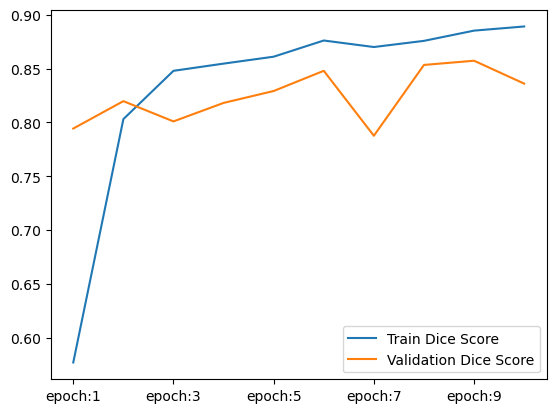

In [32]:
result_df[["Train Dice Score", "Validation Dice Score"]].plot()

<Axes: >

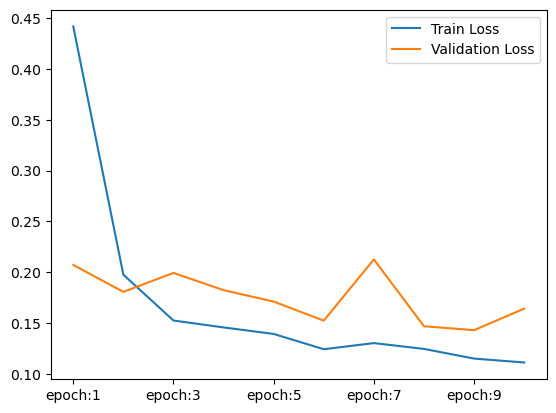

In [33]:
result_df[["Train Loss", "Validation Loss"]].plot()

In [42]:
# 모델 저장
# torch.save(infer_model.state_dict(), pth_name)

## Test

In [35]:
def Test(model, criterion, test_loader, device):
    model.eval()
    with torch.no_grad():
        for img, label in tqdm(test_loader):
            out = model(img.to(device))
            out = torch.squeeze(out)
            pred = torch.ge(out.sigmoid(), 0.5).float()
            label = torch.squeeze(label).to(device)
            score = dice_score(pred, label)
            loss = criterion(out, label.type(torch.FloatTensor).to(device))

            loss_meter.update(loss.item())
            score_meter.update(score.item())
    
        test_loss_mean = loss_meter.avg
        test_score_mean = score_meter.avg
        loss_meter.reset()
        score_meter.reset()
    
    return test_loss_mean, test_score_mean

In [36]:
# model.load_state_dict(torch.load("data/pthfile/train:20X_test:20X_epoch:20_(2023_06_01_11:52_AM).pth", map_location=device))

In [37]:
test_loss, test_score = Test(infer_model, criterion, test_loader, device)
print(f"test_loss: {test_loss}, test_score: {test_score}")

  0%|          | 0/2 [00:00<?, ?it/s]

test_loss: 0.25901129841804504, test_score: 0.7409852743148804


## 결과 저장

In [38]:
def denormalize(tensor, mean=CFG["MEAN"], std=CFG["STD"]):
    for t, m, s in zip(tensor, mean, std):
        t.mul_(s).add_(m)
    return tensor

In [39]:
import matplotlib as mpl
mpl.rcParams['image.cmap'] = 'inferno'

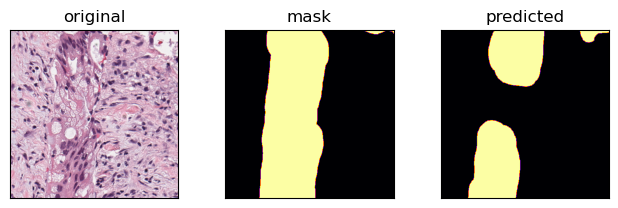

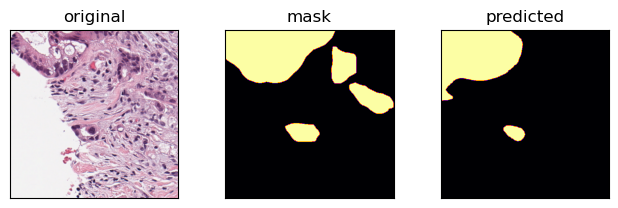

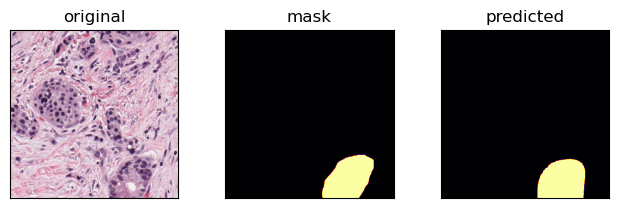

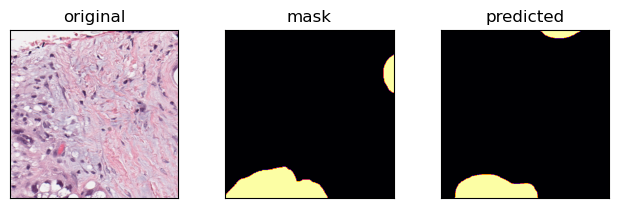

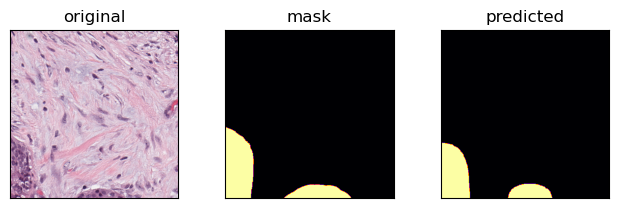

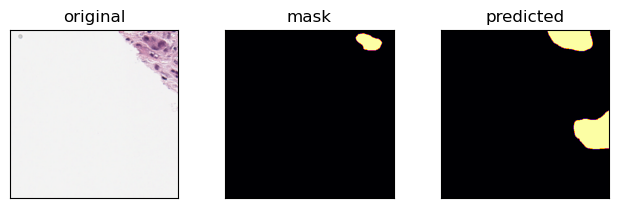

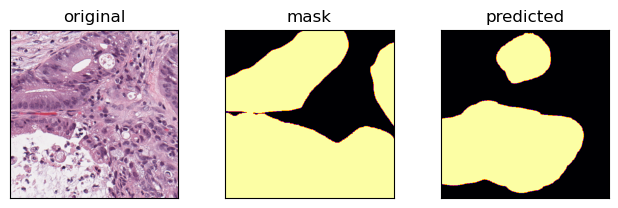

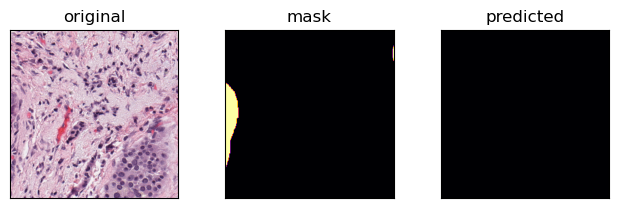

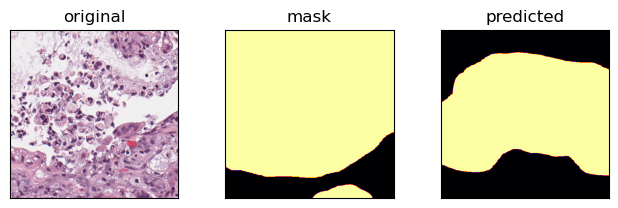

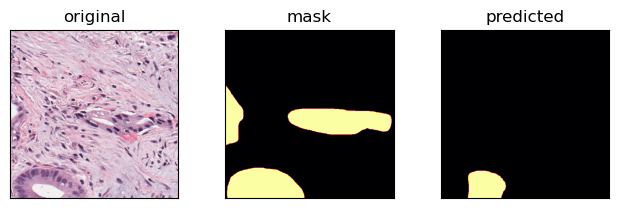

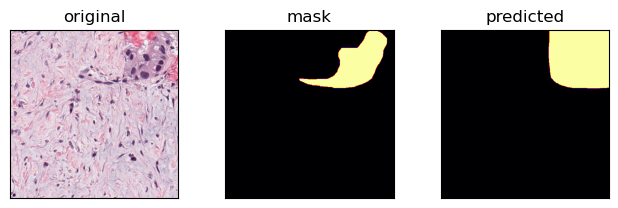

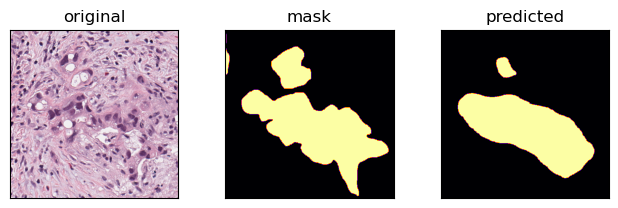

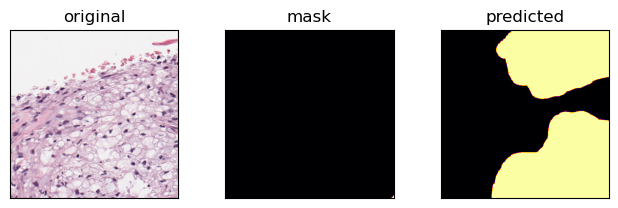

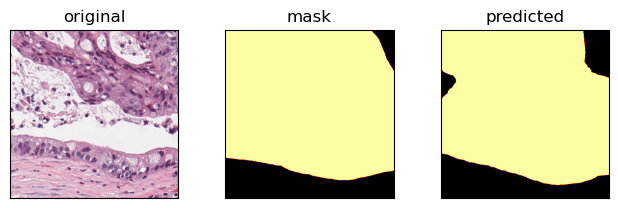

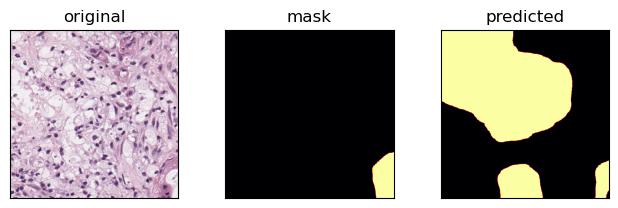

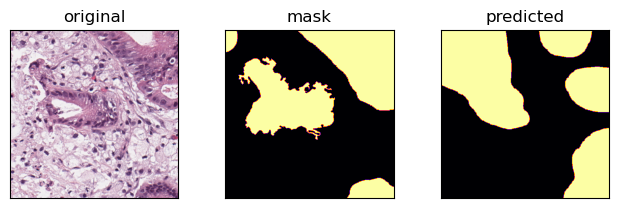

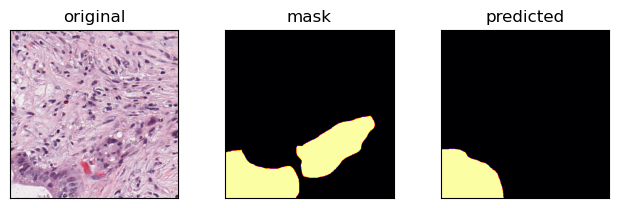

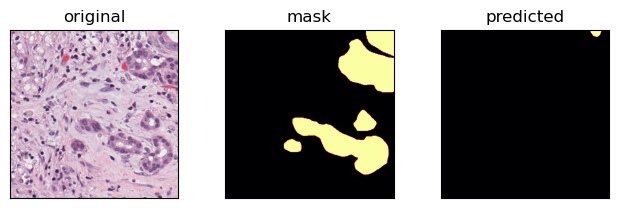

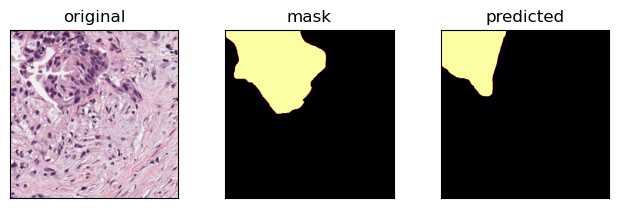

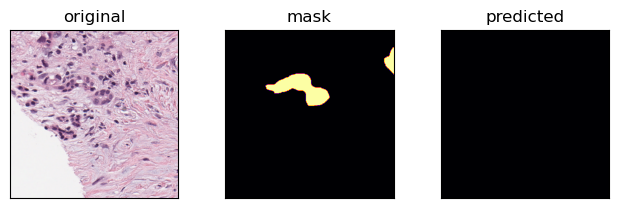

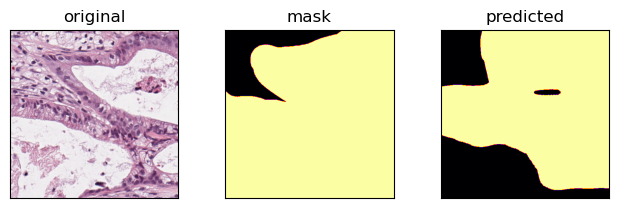

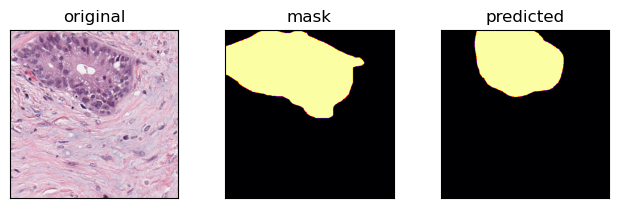

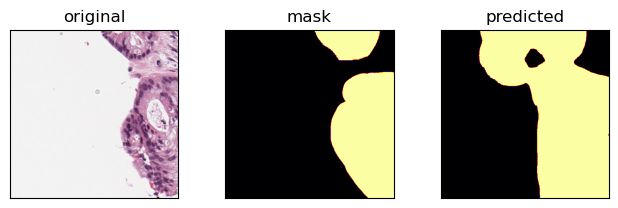

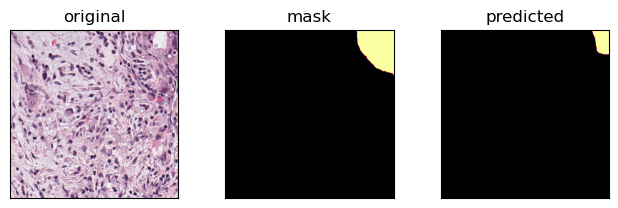

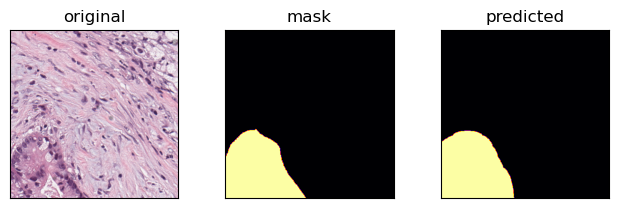

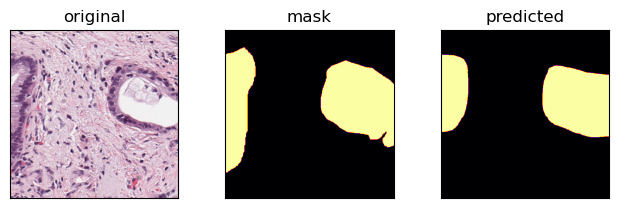

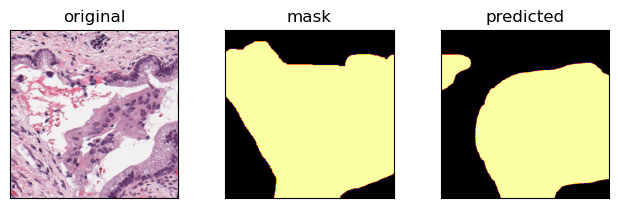

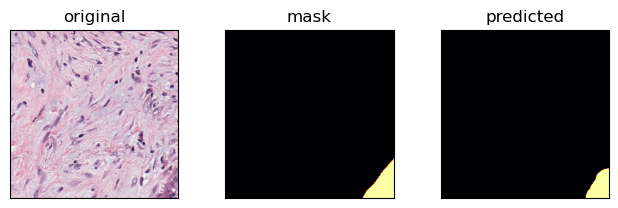

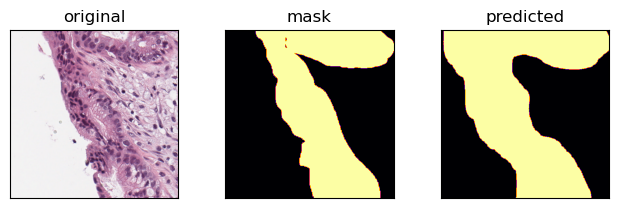

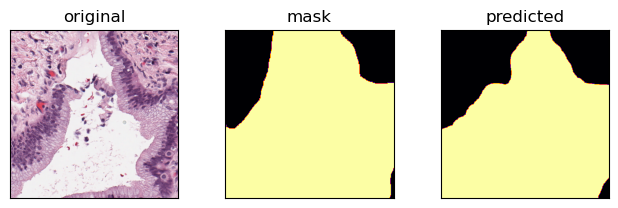

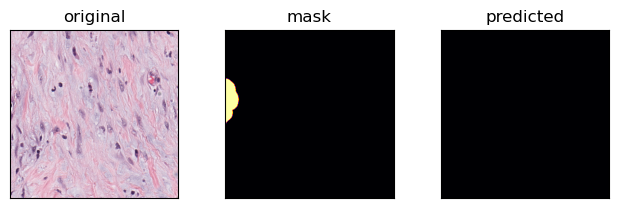

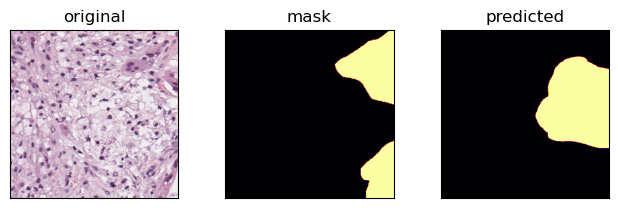

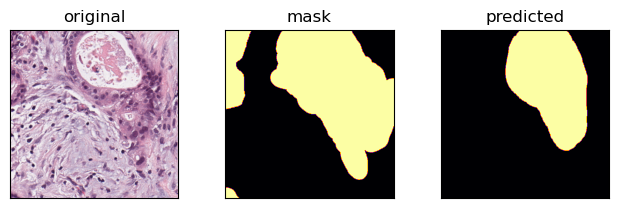

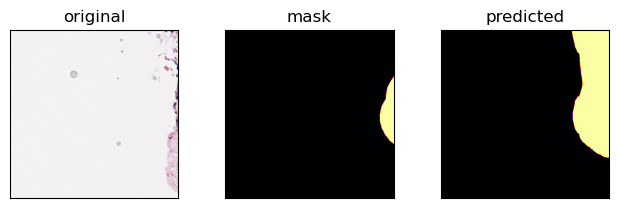

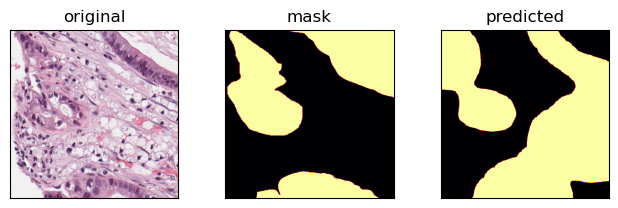

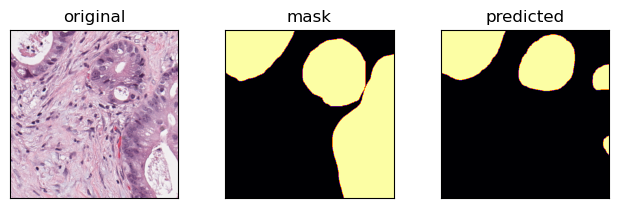

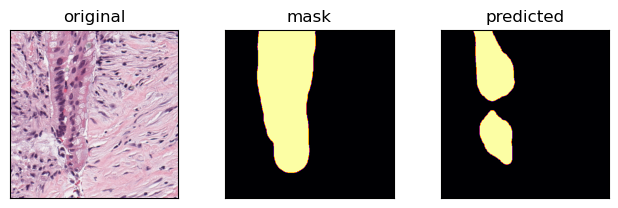

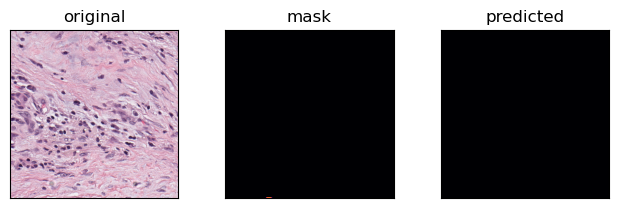

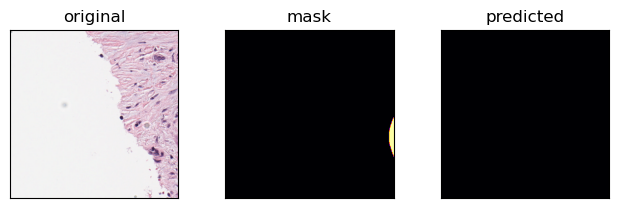

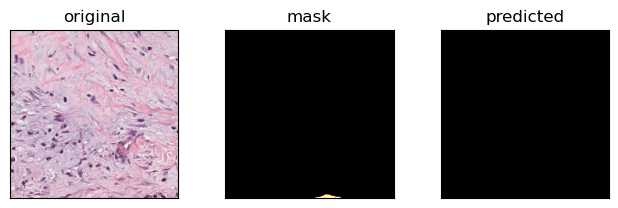

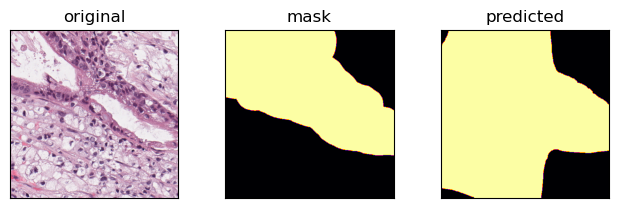

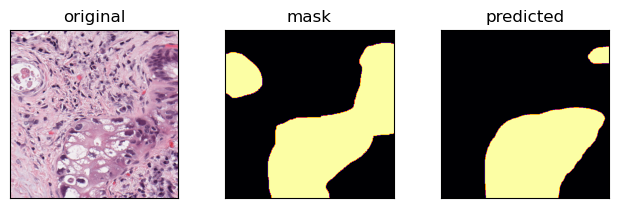

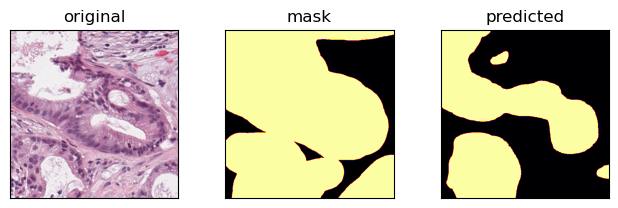

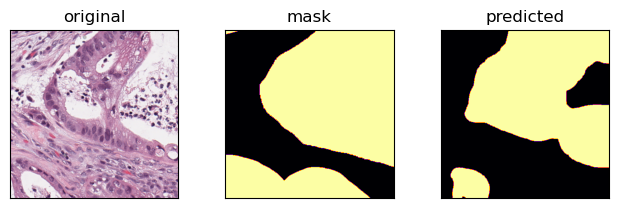

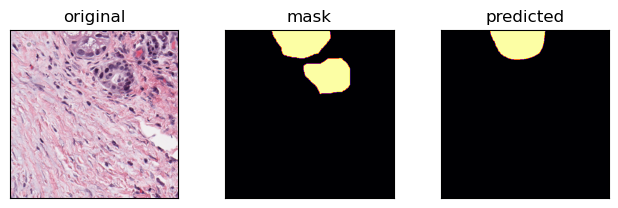

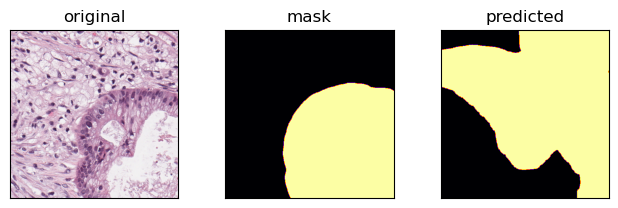

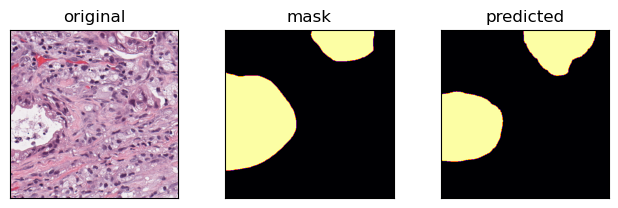

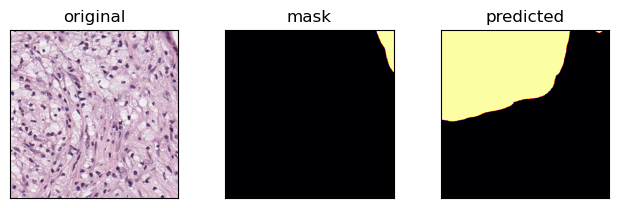

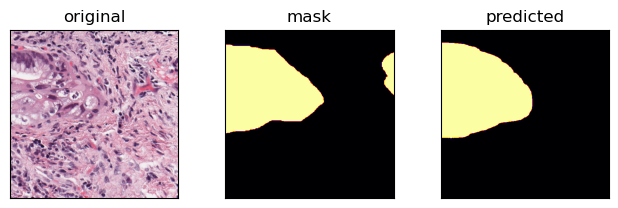

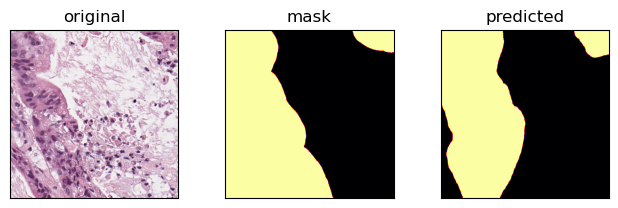

In [41]:
# output_save
os.makedirs(output_path, exist_ok=True)

for i in range(50):
    
    data, label = test_set[i]
    label = torch.squeeze(label)

    with torch.no_grad():
        out = model(torch.unsqueeze(data, dim=0).to(device))
    out = torch.squeeze(out).sigmoid().to('cpu')
    pred = torch.ge(out, 0.5).float().to('cpu')

    # 오리지널 이미지
    plt.subplot(1,3,1)
    plt.title("original")
    plt.imshow(ToPILImage()(denormalize(data)))
    plt.xticks([]); plt.yticks([])

    # 마스크 이미지
    plt.subplot(1,3,2)
    plt.title("mask")
    plt.imshow(label)
    plt.xticks([]); plt.yticks([])
    
    # 마스크 예측 이미지
    plt.subplot(1,3,3)
    plt.title("predicted")
    plt.tight_layout()
    plt.imshow(pred)
    plt.xticks([]); plt.yticks([])

    plt.show()
    # plt.savefig(f'{output_path}/{output_name}_{i+1}.png')